# How to Grid Search Triple Exponential Smoothing for Time Series Forecasting in Python

* Ref: [https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/](https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/)
* Data:
    * case 1: [https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv)
    * case 2: [https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv)
    * case 3: [https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-mean-temp.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-mean-temp.csv)
    * case 4: [https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv)

## Exponential Smoothing
* 又叫做 ETS model: Error, Trend, Seasonality
* Weight 是呈現 exponential decay
* Single exponential smoothing (SES) 也叫做 simple exponential smoothing, 沒有 trend 也沒有 seasonality
* Double exponential smoothing: 有 trend 沒有 seasonality
* Triple exponential smoothing: 有 trend 也有 seasonality
    * 可以藉由設定 configuration 變成 SES 或是 double exponential smoothing
    * holt-winter exponential smoothing
    * $\alpha$: level
    * $\beta$: trend
    * $\gamma$: seasonal
    * $\phi$: damped trend

## Grid search
用 ETS grid search 其實就只是自己 loop 所有可能的 configuration 然後選出最好的那一個

In [ ]:
# grid search holt winter's exponential smoothing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from warnings import catch_warnings, filterwarnings
%matplotlib inline
plt.style.use('fivethirtyeight')

# one-step Holt Winter's Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
  # trend, damped, seasonal, period, boxcox, remove_bias
  t, d, s, p, b, r = config

  # define model
  history = np.array(history) # ETS 吃 numpy array 或 list
  model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)

  # fit model
  model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
  # print(model_fit.params) # 顯示參數

  # make one step forecast
  yhat = model_fit.predict(len(history), len(history)) # yhat 是一個只有一個數值的 numpy array
  return yhat[0] # 這樣傳回的是數值，不是 numpy array

# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, config):
  predictions = list()

  # split dataset
  train, test = train_test_split(data, n_test)

  # seed history with training dataset
  history = [x for x in train] # 變成了 list

  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    predictions.append(yhat)

    # add actual observation to history for the next loop
    history.append(test[i])

  # estimate prediction error
  error = measure_rmse(test, predictions)
  return error

# score a model, return None on failure
def score_model(data, n_test, config, debug=False):
  result = None
  # convert config to a key
  key = str(config)

  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, config)
  else:
    # 有些 config 的組合並沒辦法拿來跑 ETS，所以要做例外處理
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings('ignore')
        result = walk_forward_validation(data, n_test, config)
    except:
      error = None

    # check for an interesting result
    if result is not None:
      print(f'> Model[{key}] {result}')

    return (key, result) # 傳回 config 還有 rmse

# grid search configs
def grid_search(data, config_list, n_test, parallel=True):
  scores = None
  if parallel: # 用多個 cpu 做平行運算
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (delayed(score_model)(data, n_test, config) for config in config_list)
    scores = executor(tasks)
  else: # loop 每個 config
    scores = [score_model(data, n_test, config) for config in config_list]

  # 當 config 的組合不好的時候，沒辦法跑 ETS，result 的部分會傳回 None，所以要把這些過濾掉
  scores = [r for r in scores if r[1] != None]

  # sort configs 因為 rmse 越小越好 所以用遞增的排序
  scores.sort(key=lambda tup: tup[1])

  return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
  models = list()

  # define config lists
  t_params = ['add', 'mul', None]
  d_params = [True, False]
  s_params = ['add', 'mul', None]
  p_params = seasonal
  b_params = [True, False]
  r_params = [True, False]

  # create config
  for t in t_params:
    for d in d_params:
      for s in s_params:
        for p in p_params:
          for b in b_params:
            for r in r_params:
              config = [t, d, s, p, b, r]
              models.append(config)

  return models

def main(data, n_test, seasonal=[None]):
  # configs
  config_list = exp_smoothing_configs(seasonal)

  # grid search
  scores = grid_search(data, config_list, n_test)
  print('done')

  # list top 3 configs
  for config, error in scores[:3]:
    print(config, error)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 先測試 grid search 有沒有問題

In [ ]:
data = [10., 20., 30., 40., 50., 60., 70., 80., 90., 100.]
n_test = 4
main(data, n_test)

> Model[['add', True, None, None, False, True]] 5.7139290748588355e-05
> Model[['add', True, None, None, True, True]] 0.9757235518727625
> Model[['add', True, None, None, False, False]] 5.6899108983322765e-05
> Model[['add', False, None, None, True, True]] 3.0175488371464785
> Model[['add', True, None, None, True, False]] 0.9777987036339436
> Model[['add', False, None, None, True, False]] 3.1242258328258288
> Model[['add', False, None, None, False, True]] 2.1596792206831395e-07
> Model[['add', False, None, None, False, False]] 7.170133758539694e-08
> Model[['mul', False, None, None, True, True]] 2.0308109792510654
> Model[['mul', False, None, None, True, False]] 2.713152510110622
> Model[['mul', False, None, None, False, True]] 1.4682005293853355
> Model[['mul', True, None, None, True, True]] 17.20422119045163
> Model[['mul', False, None, None, False, False]] 1.8587448609514678
> Model[[None, False, None, None, True, True]] 1.379824445857423
> Model[[None, False, None, None, True, Fals

### Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Case 1: 沒有 trend 也沒有 seasonality

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/daily-total-female-births.csv',
                 header=0, index_col=0, parse_dates=[0])
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Births  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


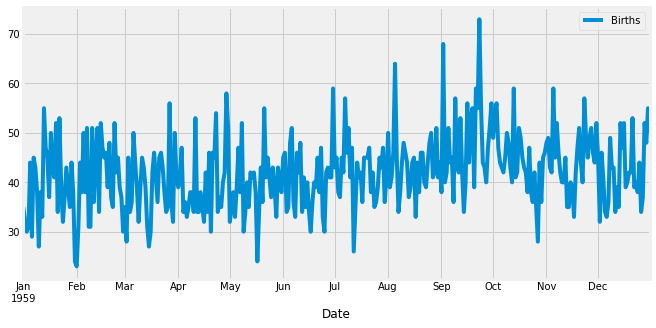

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
plt.show()

In [ ]:
data = df['Births'].values
n_test = 165
main(data, n_test)

> Model[['add', False, None, None, True, True]] 7.0893469161447396
> Model[['add', False, None, None, True, False]] 7.11439525374
> Model[['add', False, None, None, False, True]] 7.088249056764266
> Model[['add', False, None, None, False, False]] 7.097038305689389
> Model[['mul', True, None, None, True, True]] 7.11878241670764
> Model[['mul', True, None, None, True, False]] 7.16558029696429
> Model[['mul', True, None, None, False, True]] 7.112433321942917
> Model[['mul', False, None, None, True, True]] 6.99301180984521
> Model[['mul', False, None, None, True, False]] 7.015729849157782
> Model[['mul', False, None, None, False, True]] 7.181932830159424
> Model[['mul', True, None, None, False, False]] 7.119558200511135
> Model[[None, False, None, None, True, True]] 7.169325527736619
> Model[['mul', False, None, None, False, False]] 7.17481669048056
> Model[[None, False, None, None, True, False]] 7.212272315653904
> Model[[None, False, None, None, False, True]] 7.116982187087365
> Model[[N

## Case 2: 有 trend

In [ ]:
from datetime import datetime
def custom_parser(x):
  return datetime.strptime('195'+x, '%Y-%m')

# load data
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/shampoo.csv',
                 header=0, index_col=0, date_parser=custom_parser)
df.head()

,Sales
Month,
1951-01-01,266.0
1951-02-01,145.9
1951-03-01,183.1
1951-04-01,119.3
1951-05-01,180.3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1951-01-01 to 1953-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes


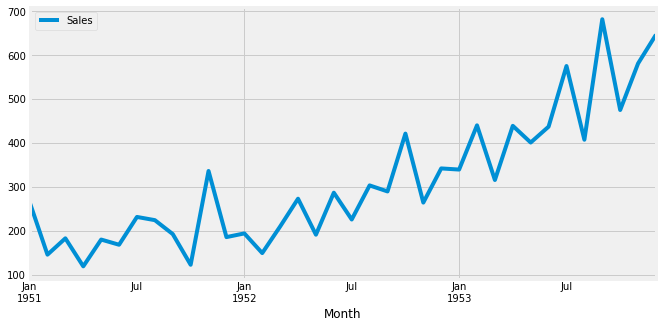

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
plt.show()

In [ ]:
data = df['Sales'].values
n_test = 12
main(data, n_test)

> Model[['add', True, None, None, False, True]] 97.91815887285195
> Model[['add', True, None, None, True, True]] 97.0456660179138
> Model[['add', True, None, None, False, False]] 103.06878140205062
> Model[['add', True, None, None, True, False]] 106.55930754896953
> Model[['add', False, None, None, True, True]] 110.29023085892774
> Model[['add', False, None, None, True, False]] 108.66468828743052
> Model[['add', False, None, None, False, True]] 106.43099793677882
> Model[['add', False, None, None, False, False]] 104.87378465161437
> Model[['mul', True, None, None, True, True]] 1561.9698151904295
> Model[['mul', True, None, None, False, True]] 102.44616585186156
> Model[['mul', True, None, None, True, False]] 106.16651300166798
> Model[['mul', False, None, None, True, True]] 110.57562011718682
> Model[['mul', True, None, None, False, False]] 102.15208420657703
> Model[['mul', False, None, None, True, False]] 108.7467662776344
> Model[[None, False, None, None, True, True]] 96.68252034213

## Case 3: 有 seasonality

In [ ]:
# load data
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/monthly-mean-temp.csv',
                 header=0, index_col=0)
df.head()

,Temperature
Month,
1920-01,40.6
1920-02,40.8
1920-03,44.4
1920-04,46.7
1920-05,54.1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 1920-01 to 1939-12
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8+ KB


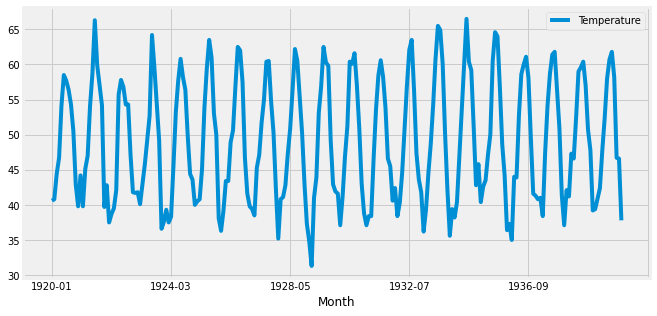

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
plt.show()

In [ ]:
data = df['Temperature'].values[-(5*12): ] # 只用最後五年的資料來做，跑的比較快
seasonal = [0, 12]
n_test = 12 # 最後一年的當作 test
main(data, n_test, seasonal)

> Model[['add', True, 'add', 12, False, True]] 1.568153508922937
> Model[['add', True, 'add', 12, True, True]] 1.6457126543702607
> Model[['add', True, 'add', 12, False, False]] 1.5545873020659413
> Model[['add', True, 'add', 12, True, False]] 1.63771154054487
> Model[['add', True, 'mul', 12, True, True]] 1.6625711057018788
> Model[['add', True, 'mul', 12, True, False]] 1.659225305680542
> Model[['add', True, 'mul', 12, False, False]] 1.6091784988390756
> Model[['add', True, 'mul', 12, False, True]] 1.602852456679028
> Model[['add', True, None, 0, True, True]] 4.65490960083377
> Model[['add', True, None, 0, True, False]] 4.59746335858041
> Model[['add', True, None, 0, False, True]] 4.800180300292032
> Model[['add', True, None, 0, False, False]] 4.760442316945397
> Model[['add', True, None, 12, True, True]] 4.65490960083377
> Model[['add', True, None, 12, True, False]] 4.59746335858041
> Model[['add', True, None, 12, False, True]] 4.800180300292032
> Model[['add', True, None, 12, False,

## Case 4: 有 trend 也有 seasonality

In [ ]:
# load data
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/monthly-car-sales.csv',
                 header=0, index_col=0)
df.head()

,Sales
Month,
1960-01,6550
1960-02,8728
1960-03,12026
1960-04,14395
1960-05,14587


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 1960-01 to 1968-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   108 non-null    int64
dtypes: int64(1)
memory usage: 1.7+ KB


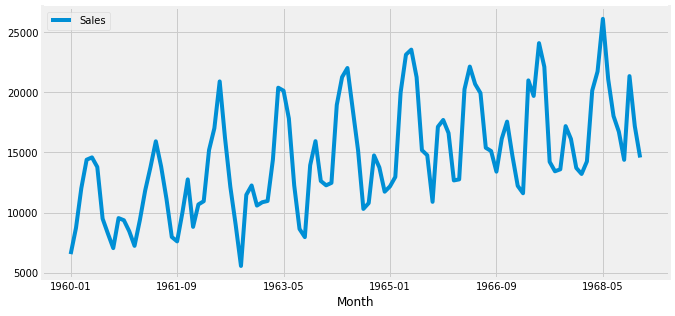

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
plt.show()

In [ ]:
data = df['Sales'].values
seasonal = [0, 6, 12]
n_test = 12
main(data, n_test, seasonal)

> Model[['add', True, 'add', 6, False, True]] 3240.432815614594
> Model[['add', True, 'add', 6, True, True]] 2761.88041746145
> Model[['add', True, 'add', 6, False, False]] 3226.3839394600964
> Model[['add', True, 'add', 6, True, False]] 2759.502101356549
> Model[['add', True, 'add', 12, True, True]] 2184.2520720021175
> Model[['add', True, 'add', 12, False, True]] 1598.780579261576
> Model[['add', True, 'add', 12, False, False]] 1611.7454265777033
> Model[['add', True, 'add', 12, True, False]] 2148.7735530735526
> Model[['add', True, 'mul', 6, True, True]] 2949.5654022373565
> Model[['add', True, 'mul', 6, True, False]] 2934.3023626829495
> Model[['add', True, 'mul', 6, False, True]] 2991.3327851976474
> Model[['add', True, 'mul', 6, False, False]] 2975.267068717269
> Model[['add', True, 'mul', 12, True, True]] 1993.7736439496446
> Model[['add', True, 'mul', 12, True, False]] 2008.7768246153328
> Model[['add', True, None, 0, True, True]] 3935.692700012156
> Model[['add', True, None, 0